## E-commerce Customer Segmentation and Prediction

### 📌 Introduction

Customer segmentation is the practice of grouping customers based on similar characteristics and purchasing behavior. Using transaction data (invoices, products, quantities, prices, customer IDs, and countries), this analysis identifies key customer groups, highlights revenue-driving segments, and uncovers buying patterns. The insights support targeted marketing, better customer retention, and improved business performance.  


## Objectives of Customer Segmentation Project  

1. **Group customers** based on their purchasing behavior and transaction history.  
2. **Identify high-value segments** that contribute the most to sales and revenue.  
3. **Analyze customer characteristics** such as frequency of purchase, spending patterns, and geography.  
4. **Support targeted marketing strategies** by understanding different customer needs.  
5. **Improve customer retention** through personalized offers and engagement.  
6. **Enhance decision-making** for product promotion, pricing, and inventory planning.  


## Problem Statement  

The company records detailed retail transactions, but it lacks insights into distinct customer groups. Without segmentation, all customers are treated the same, which limits targeted marketing and efficient resource use. This project aims to analyze purchase behavior to identify meaningful customer segments, helping the business improve marketing, retention, and overall profitability.


## Dataset Description  

The dataset contains retail transaction records, where each row represents a purchased product within a sales invoice. It includes the following fields:  

- **InvoiceNo** → Unique identifier for each transaction.  
- **StockCode** → Product code representing each item.  
- **Description** → Name of the product purchased.  
- **Quantity** → Number of units purchased for the product.  
- **InvoiceDate** → Date and time of the transaction.  
- **UnitPrice** → Price per unit of the product.  
- **CustomerID** → Unique identifier for each customer.  
- **Country** → Country where the customer resides.  


### 1. Imports & notebook setup

In [1]:
# core
import pandas as pd #Used for handling structured datasets (CSV, Excel, SQL, etc.). Makes it easy to clean, filter, transform, and analyze data.
import numpy as np #Provides fast numerical operations, especially for arrays and matrices (essential for ML computations)
import matplotlib.pyplot as plt #Core visualization library for static plots (scatterplots, histograms, etc.).
import matplotlib as mpl #Core visualization library for static plots (scatterplots, histograms, etc.).
import seaborn as sns #Built on matplotlib, gives you prettier, statistical-style plots with fewer lines of code.
import datetime #Helps with date/time operations (parsing timestamps, calculating differences, grouping by time).
import warnings #Lets you ignore unnecessary warning messages (useful for cleaner notebook outputs).
import matplotlib.patches as mpatches

# sklearn
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.decomposition import PCA


# plotting helper
import plotly.graph_objs as go
from plotly.offline import iplot, init_notebook_mode
init_notebook_mode(connected=True)

# misc
warnings.filterwarnings('ignore')


In [2]:
# load CSV (update path as needed)
df = pd.read_csv('data.csv', encoding='ISO-8859-1',
dtype={'CustomerID': str, 'InvoiceNo': str, 'StockCode': str})
print('raw shape', df.shape)

raw shape (541909, 8)


In [3]:
# quick glance
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  object 
 7   Country      541909 non-null  object 
dtypes: float64(1), int64(1), object(6)
memory usage: 33.1+ MB


In [4]:
# parse datetimes
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], errors='coerce')

In [5]:
# missing counts
missing = pd.DataFrame(df.isnull().sum(), columns=['missing']).T
missing_pct = (missing / len(df) * 100).round(3)
print(missing)
print(missing_pct)

         InvoiceNo  StockCode  Description  Quantity  InvoiceDate  UnitPrice  \
missing          0          0         1454         0            0          0   

         CustomerID  Country  
missing      135080        0  
         InvoiceNo  StockCode  Description  Quantity  InvoiceDate  UnitPrice  \
missing        0.0        0.0        0.268       0.0          0.0        0.0   

         CustomerID  Country  
missing      24.927      0.0  


### 2. Data Cleaning

In [6]:
# Trim text fields
if 'Description' in df.columns:
    df['Description'] = df['Description'].astype(str).str.strip()

print("Missing Description:", df['Description'].isna().sum())

#Drop null in CusomterId 
df = df.dropna(subset=['CustomerID'])
# Verify the missing count after dropping
print("Missing CustomerID after drop:", df['CustomerID'].isna().sum(), " / ", len(df))

Missing Description: 0
Missing CustomerID after drop: 0  /  406829


In [7]:
df.shape

(406829, 8)

In [8]:
# Drop exact duplicate rows
dup_before = df.duplicated().sum()
df = df.drop_duplicates()
print(f"Dropped {dup_before} duplicate rows. New shape: {df.shape}")

Dropped 5225 duplicate rows. New shape: (401604, 8)


#### Countries

In [9]:
temp_cou = df[['CustomerID', 'InvoiceNo', 'Country']].groupby(['CustomerID', 'InvoiceNo', 'Country']).count()

# Add an index number 
# reset_index() is a method to reset index of a Data Frame.
# reset_index() method sets a list of integer ranging from 0 to length of data as index.
temp_cou = temp_cou.reset_index(drop = False)




In [10]:
# Take count of the number of unique countries
countries = temp_cou['Country'].value_counts()
print('No. of countries in the dataframe: {}'.format(len(countries)))

No. of countries in the dataframe: 37


In [11]:

data = go.Scattergeo(
    locationmode='country names',
    locations=countries.index,
    text=[f"{c}: {v}" for c, v in zip(countries.index, countries.values)],
    mode='markers',
    marker=dict(
        size=[max(v/5, 5) for v in countries.values],  # adjust scaling
        color=countries.values,
        colorscale='Viridis',
        showscale=True,
        colorbar=dict(title="Order Count")
    )
)

layout = go.Layout(
    title="Orders per Country (Bubble Map)",
    geo=dict(
        showframe=False,
        showcoastlines=True,
        projection=dict(type="equirectangular")
    )
)

fig = go.Figure(data=[data], layout=layout)
iplot(fig, validate=False)

From the map, you'll see that the dataset is largely dominated by orders made from the first five countries:

- **United Kingdom** — 19,857 customers  
- **Germany** — 603 customers  
- **France** — 458 customers  
- **EIRE** — 319 customers  
- **Belgium** — 119 customers  


#### Customers and products

In [12]:
pd.DataFrame([{'products': len(df['StockCode'].value_counts()),    
               'transactions': len(df['InvoiceNo'].value_counts()),
               'customers': len(df['CustomerID'].value_counts()),}], 
             columns = ['products', 'transactions', 'customers'], index = ['quantity'])

,products,transactions,customers
quantity,3684,22190,4372


- The dataset concerns **4,372 users**  
- They bought **3,684 different products**  
- The total number of transactions carried out is approximately **22,190**  


### Understand cancellations & negative quantities

Retail datasets often encode returns / cancellations as negative Quantity and potentially prefixed invoice numbers with C.

We will create a small QuantityCanceled column that tries to match cancellations to prior positive lines of the same customer & stock code;

remove standalone cancellation lines (no positive counterpart historically in dataset) only when appropriate.

The pairing algorithm below is conservative: it tries to find a positive line for the same CustomerID & StockCode with InvoiceDate earlier than the cancellation, and then marks that positive line's QuantityCanceled accordingly.

In [13]:
temp_pro = df.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['InvoiceDate'].count()

# Rename the InvoiceDate to number of products
nb_products_per_basket = temp_pro.rename(columns = {'InvoiceDate':'Number of products'})

# Sort in Ascending order based on CustomerID
nb_products_per_basket[:10].sort_values('CustomerID') # List first 10 values

# Create a new column(order_canceled) and assign/take count of the canceled InvoiceNo values
nb_products_per_basket['order_canceled'] = nb_products_per_basket['InvoiceNo'].apply(lambda x:int('C' in x)) 
display(nb_products_per_basket[:5])

# Sum total of order_canceled
n1 = nb_products_per_basket['order_canceled'].sum()

# Sum of rows
n2 = nb_products_per_basket.shape[0]

# Divide by 100 to get the percentage value
print('Number of orders canceled: {}/{} ({:.2f}%) '.format(n1, n2, n1/n2*100))

,CustomerID,InvoiceNo,Number of products,order_canceled
0,12346,541431,1,0
1,12346,C541433,1,1
2,12347,537626,31,0
3,12347,542237,29,0
4,12347,549222,24,0


Number of orders canceled: 3654/22190 (16.47%) 


In [14]:
df_cleaned = df.copy()  # made a copy of dataset
df_cleaned['QuantityCanceled'] = 0      # initialize the new varaible in the dataframe

# 
entry_to_remove = [] ; doubtfull_entry = []


for index, col in  df.iterrows():
    if (col['Quantity'] > 0) or col['Description'] == 'Discount': continue        
    df_test = df[(df['CustomerID'] == col['CustomerID']) &
                         (df['StockCode']  == col['StockCode']) & 
                         (df['InvoiceDate'] < col['InvoiceDate']) & 
                         (df['Quantity']   > 0)].copy()
    
    # Cancelation WITHOUT counterpart
    if (df_test.shape[0] == 0): 
        doubtfull_entry.append(index)
        
    # Cancelation WITH a counterpart
    elif (df_test.shape[0] == 1): 
        index_order = df_test.index[0]
        df_cleaned.loc[index_order, 'QuantityCanceled'] = -col['Quantity']
        entry_to_remove.append(index) 
        
    # Various counterparts exist in orders: we delete the last one
    elif (df_test.shape[0] > 1): 
        df_test.sort_index(axis=0 ,ascending=False, inplace = True)        
        for ind, val in df_test.iterrows():
            if val['Quantity'] < -col['Quantity']: continue
            df_cleaned.loc[ind, 'QuantityCanceled'] = -col['Quantity']
            entry_to_remove.append(index) 
           


In the above function, I checked the two cases:

a cancel order exists without counterpart

there's at least one counterpart with the exact same quantity

The index of the corresponding cancel order are respectively kept in the doubtfull_entry and entry_to_remove lists whose sizes are:

In [15]:
print("entry_to_remove: {}".format(len(entry_to_remove)))
print("doubtfull_entry: {}".format(len(doubtfull_entry)))

entry_to_remove: 14534
doubtfull_entry: 1226


Among these entries, the lines listed in the **doubtfull_entry** list correspond to the entries indicating a **cancellation** but for which there is no command beforehand. In practice, I decided to delete all of these entries, which count respectively for  **∼ 1.4%** and **0.2%** of the dataframe entries.

Now I check the number of entries that correspond to cancellations and that have not been deleted with the previous filter:

In [16]:
# Drop the `entry_to_remove` and `doubtfull_entry` accross the row axis
df_cleaned.drop(entry_to_remove, axis = 0, inplace = True)
df_cleaned.drop(doubtfull_entry, axis = 0, inplace = True)

In [17]:
remaining_entries = df_cleaned[(df_cleaned['Quantity'] < 0) & (df_cleaned['StockCode'] != 'D')]
print("no of entries to delete: {}".format(remaining_entries.shape[0]))
remaining_entries.head(5)

no of entries to delete: 48


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,QuantityCanceled
77598,C542742,84535B,FAIRY CAKES NOTEBOOK A6 SIZE,-94,2011-01-31 16:26:00,0.65,15358,United Kingdom,0
90444,C544038,22784,LANTERN CREAM GAZEBO,-4,2011-02-15 11:32:00,4.95,14659,United Kingdom,0
111968,C545852,22464,HANGING METAL HEART LANTERN,-5,2011-03-07 13:49:00,1.65,14048,United Kingdom,0
116064,C546191,47566B,TEA TIME PARTY BUNTING,-35,2011-03-10 10:57:00,0.70,16422,United Kingdom,0
132642,C547675,22263,FELT EGG COSY LADYBIRD,-49,2011-03-24 14:07:00,0.66,17754,United Kingdom,0


In [18]:
remaining_entries.sort_index(axis=0)[:5]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,QuantityCanceled
77598,C542742,84535B,FAIRY CAKES NOTEBOOK A6 SIZE,-94,2011-01-31 16:26:00,0.65,15358,United Kingdom,0
90444,C544038,22784,LANTERN CREAM GAZEBO,-4,2011-02-15 11:32:00,4.95,14659,United Kingdom,0
111968,C545852,22464,HANGING METAL HEART LANTERN,-5,2011-03-07 13:49:00,1.65,14048,United Kingdom,0
116064,C546191,47566B,TEA TIME PARTY BUNTING,-35,2011-03-10 10:57:00,0.70,16422,United Kingdom,0
132642,C547675,22263,FELT EGG COSY LADYBIRD,-49,2011-03-24 14:07:00,0.66,17754,United Kingdom,0


In [19]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 392857 entries, 0 to 541908
Data columns (total 9 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   InvoiceNo         392857 non-null  object        
 1   StockCode         392857 non-null  object        
 2   Description       392857 non-null  object        
 3   Quantity          392857 non-null  int64         
 4   InvoiceDate       392857 non-null  datetime64[ns]
 5   UnitPrice         392857 non-null  float64       
 6   CustomerID        392857 non-null  object        
 7   Country           392857 non-null  object        
 8   QuantityCanceled  392857 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(2), object(5)
memory usage: 30.0+ MB


####  StockCode

In [20]:
List_special_codes=df_cleaned[df_cleaned['StockCode'].str.contains('^[a-zA-Z]+', regex= True)]['StockCode'].unique()
List_special_codes

array(['POST', 'D', 'C2', 'M', 'BANK CHARGES', 'PADS', 'DOT'],
      dtype=object)

In [21]:
# Pick this uniques characters from Description that corresponds to the special codes

for code in List_special_codes:
    description = df_cleaned[df_cleaned['StockCode'] == code]['Description'].unique()[0]
    print("{:<15} -> {:>30}".format(code, description))


POST            ->                        POSTAGE
D               ->                       Discount
C2              ->                       CARRIAGE
M               ->                         Manual
BANK CHARGES    ->                   Bank Charges
PADS            ->     PADS TO MATCH ALL CUSHIONS
DOT             ->                 DOTCOM POSTAGE


#### Basket Price

In [22]:
df_cleaned['TotalPrice'] = df_cleaned['UnitPrice'] * (df_cleaned['Quantity'] - df_cleaned['QuantityCanceled'])
df_cleaned.sort_values('CustomerID')[:5]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,QuantityCanceled,TotalPrice
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.04,12346,United Kingdom,74215,0.0
148288,549222,22375,AIRLINE BAG VINTAGE JET SET BROWN,4,2011-04-07 10:43:00,4.25,12347,Iceland,0,17.0
428971,573511,22698,PINK REGENCY TEACUP AND SAUCER,12,2011-10-31 12:25:00,2.95,12347,Iceland,0,35.4
428970,573511,47559B,TEA TIME OVEN GLOVE,10,2011-10-31 12:25:00,1.25,12347,Iceland,0,12.5
428969,573511,47567B,TEA TIME KITCHEN APRON,6,2011-10-31 12:25:00,5.95,12347,Iceland,0,35.7


In [23]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 392857 entries, 0 to 541908
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   InvoiceNo         392857 non-null  object        
 1   StockCode         392857 non-null  object        
 2   Description       392857 non-null  object        
 3   Quantity          392857 non-null  int64         
 4   InvoiceDate       392857 non-null  datetime64[ns]
 5   UnitPrice         392857 non-null  float64       
 6   CustomerID        392857 non-null  object        
 7   Country           392857 non-null  object        
 8   QuantityCanceled  392857 non-null  int64         
 9   TotalPrice        392857 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(2), object(5)
memory usage: 33.0+ MB


In [24]:
# Save df_cleaned to CSV
#df_cleaned.to_csv("df_cleaned.csv", index=False)


In [25]:
df_cleaned['InvoiceDate_int'] = df_cleaned['InvoiceDate'].astype('int64')
df_cleaned[:5]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,QuantityCanceled,TotalPrice,InvoiceDate_int
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,0,15.30,1291191960000000000
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,0,20.34,1291191960000000000
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,0,22.00,1291191960000000000
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,0,20.34,1291191960000000000
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,0,20.34,1291191960000000000


In [26]:
# sum of purchases / user & order
temp_sum = df_cleaned.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['TotalPrice'].sum()
basket_price = temp_sum.rename(columns = {'TotalPrice':'Basket Price'})

# date of the order
df_cleaned['InvoiceDate_int'] = df_cleaned['InvoiceDate'].astype('int64')
temp_date = df_cleaned.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['InvoiceDate_int'].mean()
df_cleaned.drop('InvoiceDate_int', axis = 1, inplace = True)
basket_price.loc[:, 'InvoiceDate'] = pd.to_datetime(temp_date['InvoiceDate_int'])

# selection of significant entries:
basket_price = basket_price[basket_price['Basket Price'] > 0]
basket_price.sort_values('CustomerID')[:6]

,CustomerID,InvoiceNo,Basket Price,InvoiceDate
1,12347,537626,711.79,2010-12-07 14:57:00.000000000
2,12347,542237,475.39,2011-01-26 14:29:59.999999744
3,12347,549222,636.25,2011-04-07 10:43:00.000000000
4,12347,556201,382.52,2011-06-09 13:01:00.000000000
5,12347,562032,584.91,2011-08-02 08:48:00.000000000
6,12347,573511,1294.32,2011-10-31 12:25:00.000000000


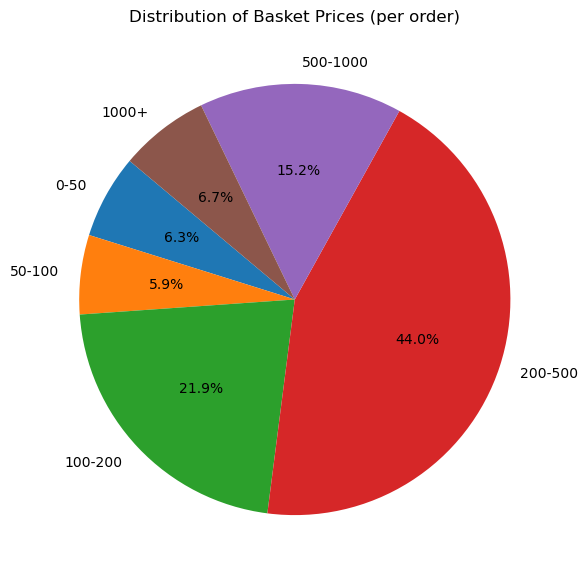

In [27]:

# Define ranges of basket amounts
bins = [0, 50, 100, 200, 500, 1000, basket_price['Basket Price'].max()]
labels = ['0-50', '50-100', '100-200', '200-500', '500-1000', '1000+']

# Cut basket prices into ranges
basket_price['Price Range'] = pd.cut(basket_price['Basket Price'], bins=bins, labels=labels, right=False)

# Count frequency of each range
range_counts = basket_price['Price Range'].value_counts().sort_index()

# Plot pie chart
plt.figure(figsize=(7,7))
plt.pie(range_counts, labels=range_counts.index, autopct='%1.1f%%', startangle=140)
plt.title("Distribution of Basket Prices (per order)")
plt.show()

In [28]:
basket_price.max(), basket_price.min()

(CustomerID                    18287
 InvoiceNo                    581587
 Basket Price                30757.0
 InvoiceDate     2011-12-09 12:50:00
 Price Range                   1000+
 dtype: object,
 CustomerID                    12347
 InvoiceNo                    536365
 Basket Price                   0.38
 InvoiceDate     2010-12-01 08:26:00
 Price Range                    0-50
 dtype: object)

#### Products Description

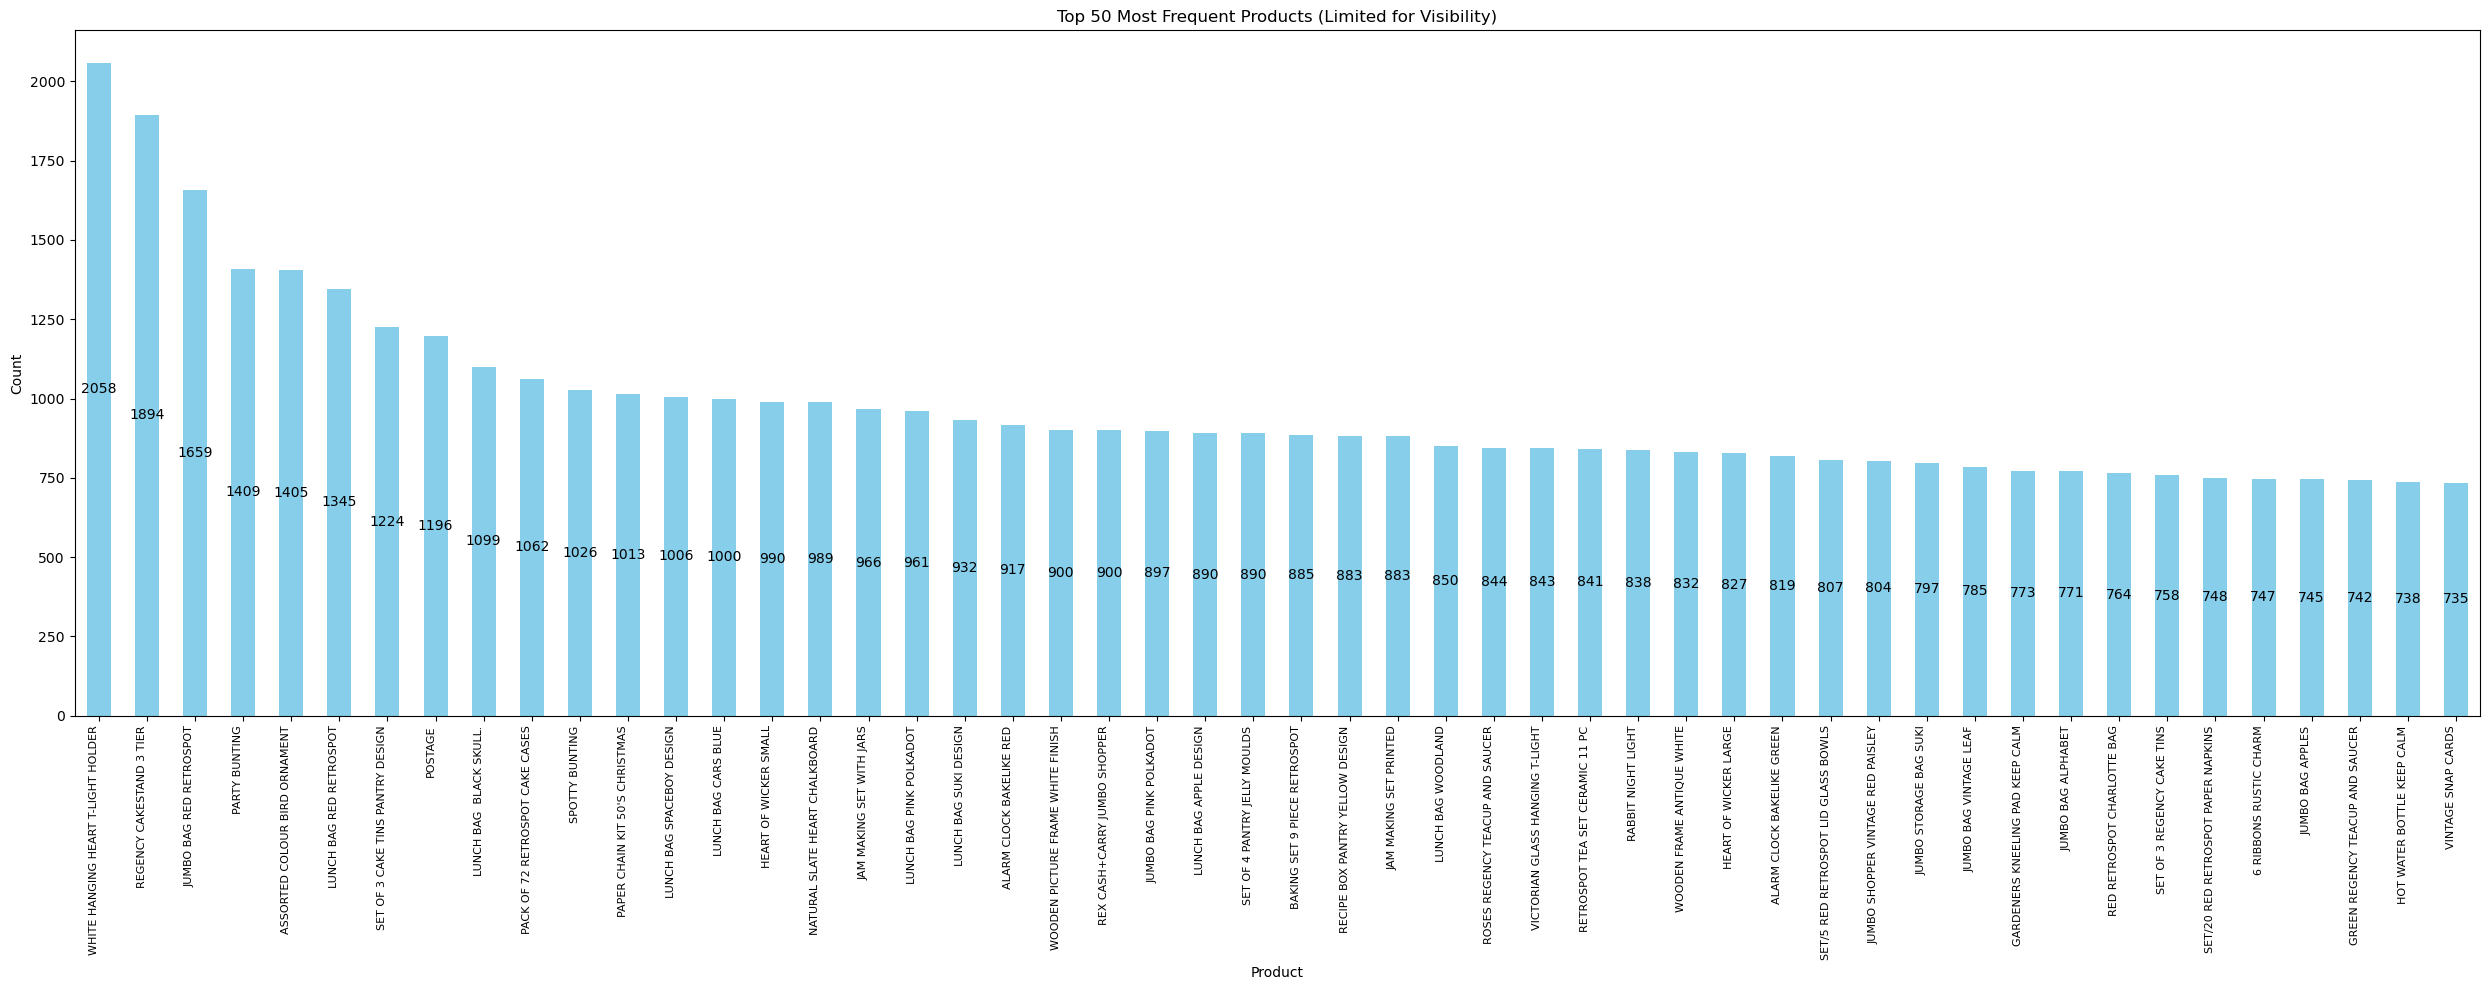

In [29]:
# Count product frequencies (all products)
product_counts = df['Description'].value_counts()

# Limit to top 50 to avoid rendering issues and improve readability
# There appear to be thousands of unique products, making a full plot impractical due to size limits and readability
if len(product_counts) > 50:
    product_counts = product_counts.head(50)
    title = "Top 50 Most Frequent Products (Limited for Visibility)"
else:
    title = "Frequency of All Products"

# Vertical bar chart
plt.figure(figsize=(max(10, len(product_counts) * 0.5), 10))  # Adjust width based on number of products, height fixed
ax = product_counts.plot(kind='bar', color='skyblue')

# Add labels inside the bars or on top if bar is short
for p in ax.patches:
    height = p.get_height()
    if height > 20:  # Threshold for placing inside
        y_pos = height / 2
        va = 'center'
    else:
        y_pos = height
        va = 'bottom'
    ax.text(
        p.get_x() + p.get_width() / 2.,
        y_pos,
        str(int(height)),
        ha='center',
        va=va,
        color='black',
        fontsize=10
    )

plt.title(title)
plt.xlabel("Product")
plt.ylabel("Count")
plt.xticks(rotation=90, ha='right', fontsize=8)  # Rotate labels for better readability
plt.tight_layout()  # Adjust layout to fit labels
plt.show()

In [30]:
df1=pd.read_csv("df_cleaned.csv")

In [31]:
# Statistical summary
print("\nStatistical summary:")
df1.describe()


Statistical summary:


,Quantity,UnitPrice,CustomerID,QuantityCanceled,TotalPrice
count,392857.000000,392857.000000,392857.000000,392857.000000,392857.000000
mean,13.143587,3.139151,15287.588204,0.746160,21.061064
std,181.564772,22.466373,1713.458613,175.574275,69.990020
min,-720.000000,0.000000,12346.000000,0.000000,-4161.060000
25%,2.000000,1.250000,13955.000000,0.000000,4.560000
50%,6.000000,1.950000,15150.000000,0.000000,11.700000
75%,12.000000,3.750000,16791.000000,0.000000,19.500000
max,80995.000000,8142.750000,18287.000000,80995.000000,8142.750000


### 3. Feature Engineering

In [32]:
# Feature Engineering - Create customer-level features

# Ensure InvoiceDate is datetime
df1['InvoiceDate'] = pd.to_datetime(df1['InvoiceDate'], errors='coerce')

# Re-run your aggregation
customer_features = df1.groupby('CustomerID').agg({
    'InvoiceNo': 'nunique',
    'TotalPrice': ['sum', 'mean'],
    'Quantity': ['sum', 'mean'],
    'InvoiceDate': ['min', 'max']
}).reset_index()

# Flatten column names
customer_features.columns = [
    'CustomerID', 'NumTransactions', 'TotalSpending', 'AvgTransactionValue',
    'TotalQuantity', 'AvgQuantityPerTransaction', 'FirstPurchaseDate', 'LastPurchaseDate'
]

# Compute lifespan (days between first and last purchase)
customer_features['CustomerLifespan'] = (
    customer_features['LastPurchaseDate'] - customer_features['FirstPurchaseDate']
).dt.days

# Compute recency (days since last purchase compared to dataset end)
last_date = df1['InvoiceDate'].max()
customer_features['Recency'] = (last_date - customer_features['LastPurchaseDate']).dt.days

# Compute frequency
customer_features['Frequency'] = customer_features['NumTransactions'] / (customer_features['CustomerLifespan'] + 1)

print("Customer features shape:", customer_features.shape)
customer_features.head(10)


Customer features shape: (4339, 11)


,CustomerID,NumTransactions,TotalSpending,AvgTransactionValue,TotalQuantity,AvgQuantityPerTransaction,FirstPurchaseDate,LastPurchaseDate,CustomerLifespan,Recency,Frequency
0,12346,1,0.00,0.000000,74215,74215.000000,2011-01-18 10:01:00,2011-01-18 10:01:00,0,325,1.000000
1,12347,7,4310.00,23.681319,2458,13.505495,2010-12-07 14:57:00,2011-12-07 15:52:00,365,1,0.019126
2,12348,4,1797.24,57.975484,2341,75.516129,2010-12-16 19:09:00,2011-09-25 13:13:00,282,74,0.014134
3,12349,1,1757.55,24.076027,631,8.643836,2011-11-21 09:51:00,2011-11-21 09:51:00,0,18,1.000000
4,12350,1,334.40,19.670588,197,11.588235,2011-02-02 16:01:00,2011-02-02 16:01:00,0,309,1.000000
5,12352,8,2365.91,27.834235,536,6.305882,2011-02-16 12:33:00,2011-11-03 14:37:00,260,35,0.030651
6,12353,1,89.00,22.250000,20,5.000000,2011-05-19 17:47:00,2011-05-19 17:47:00,0,203,1.000000
7,12354,1,1079.40,18.610345,530,9.137931,2011-04-21 13:11:00,2011-04-21 13:11:00,0,231,1.000000
8,12355,1,459.40,35.338462,240,18.461538,2011-05-09 13:49:00,2011-05-09 13:49:00,0,213,1.000000
9,12356,3,2811.43,47.651356,1591,26.966102,2011-01-18 09:50:00,2011-11-17 08:40:00,302,22,0.009901


Feature distributions:
       NumTransactions  TotalSpending  AvgTransactionValue  TotalQuantity  \
count      4339.000000    4339.000000          4339.000000    4339.000000   
mean          4.294077    1906.887814            32.935099    1190.032265   
std           7.816810    8254.620731           114.649963    5051.399167   
min           1.000000       0.000000             0.000000       1.000000   
25%           1.000000     300.390000            11.785396     159.000000   
50%           2.000000     653.380000            17.365567     378.000000   
75%           5.000000    1614.610000            24.274497     990.500000   
max         211.000000  278277.020000          3861.000000  197490.000000   

       AvgQuantityPerTransaction  CustomerLifespan      Recency    Frequency  
count                4339.000000       4339.000000  4339.000000  4339.000000  
mean                   47.921240        130.457940    91.480295     0.406917  
std                  1218.150187        132.02

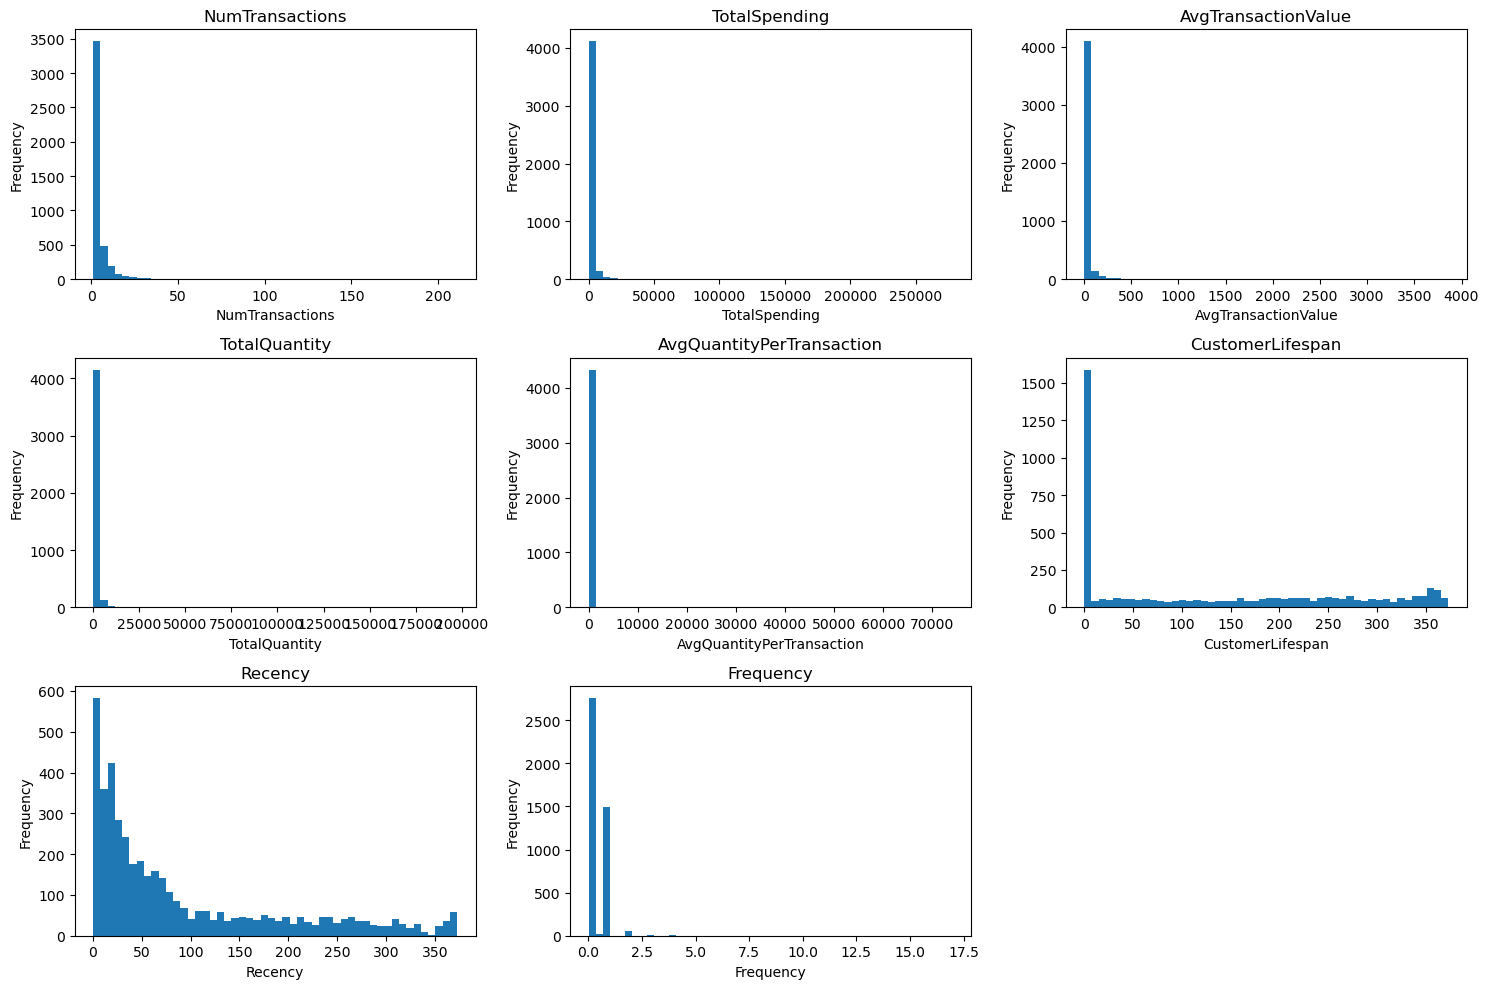

In [33]:
# Remove CustomerID for scaling and analysis
customer_data = customer_features.drop(['CustomerID', 'FirstPurchaseDate', 'LastPurchaseDate'], axis=1)

# Check the distribution of features
print("Feature distributions:")
print(customer_data.describe())

# Visualize feature distributions
plt.figure(figsize=(15, 10))
for i, column in enumerate(customer_data.columns):
    plt.subplot(3, 3, i+1)
    plt.hist(customer_data[column], bins=50)
    plt.title(column)
    plt.xlabel(column)
    plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

## 4. Dimensionality Reduction

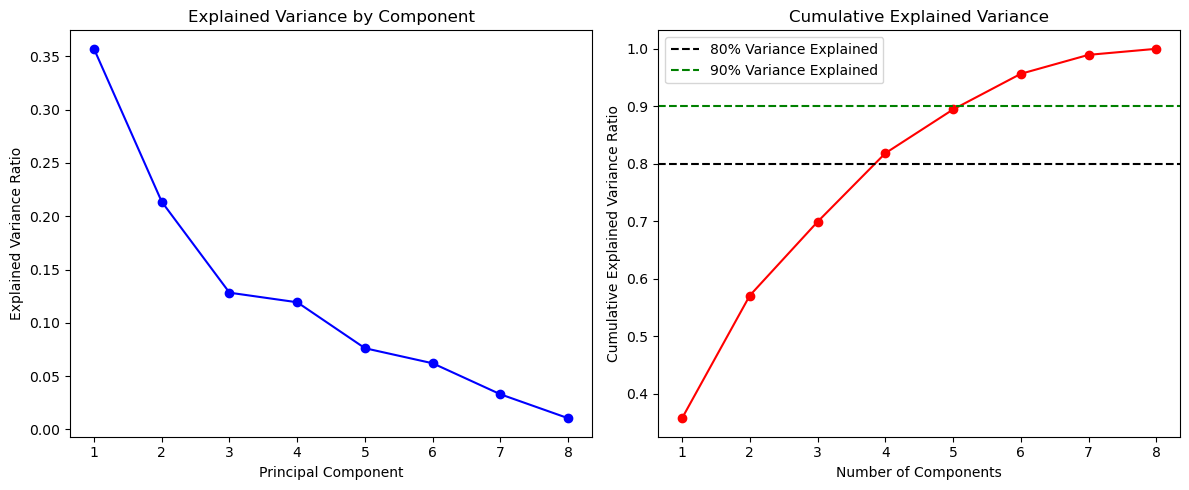

Explained variance ratio by component:
PC1: 0.3570 (0.3570 cumulative)
PC2: 0.2136 (0.5706 cumulative)
PC3: 0.1283 (0.6989 cumulative)
PC4: 0.1193 (0.8182 cumulative)
PC5: 0.0762 (0.8944 cumulative)
PC6: 0.0621 (0.9565 cumulative)
PC7: 0.0330 (0.9895 cumulative)
PC8: 0.0105 (1.0000 cumulative)


In [34]:
from sklearn.preprocessing import StandardScaler


# Standardize the features
scaler = StandardScaler()
customer_data_scaled = scaler.fit_transform(customer_data)

# Perform PCA
pca = PCA()
customer_pca = pca.fit_transform(customer_data_scaled)

# Determine optimal number of components
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance_ratio = np.cumsum(explained_variance_ratio)

# Plot explained variance
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, 'bo-')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance by Component')

plt.subplot(1, 2, 2)
plt.plot(range(1, len(cumulative_variance_ratio) + 1), cumulative_variance_ratio, 'ro-')
plt.axhline(y=0.8, color='k', linestyle='--', label='80% Variance Explained')
plt.axhline(y=0.9, color='g', linestyle='--', label='90% Variance Explained')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('Cumulative Explained Variance')
plt.legend()
plt.tight_layout()
plt.show()

# Print explained variance ratios
print("Explained variance ratio by component:")
for i, ratio in enumerate(explained_variance_ratio):
    print(f"PC{i+1}: {ratio:.4f} ({cumulative_variance_ratio[i]:.4f} cumulative)")

For k=2, silhouette score: 0.4563
For k=3, silhouette score: 0.4750
For k=4, silhouette score: 0.4755
For k=5, silhouette score: 0.4805
For k=6, silhouette score: 0.4791
For k=7, silhouette score: 0.4898
For k=8, silhouette score: 0.4160
For k=9, silhouette score: 0.4172
For k=10, silhouette score: 0.4161


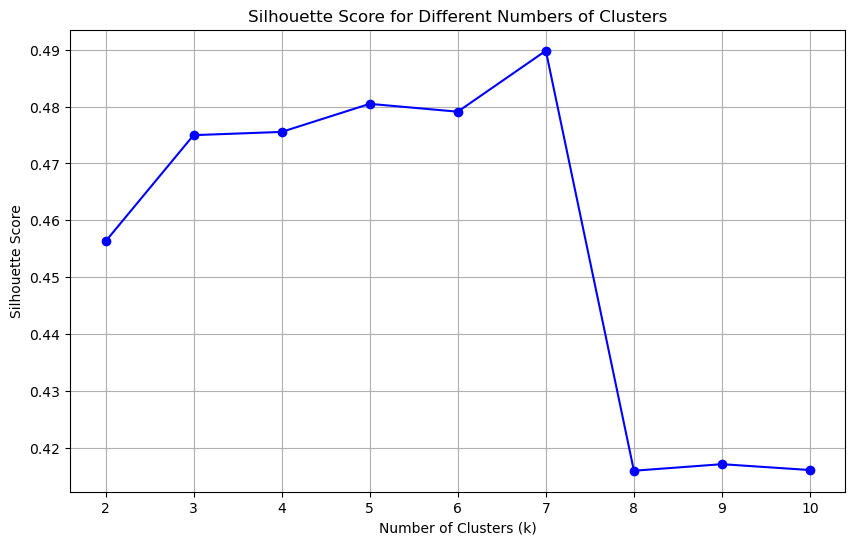


Clustering with k=3
Silhouette Score: 0.4750

Cluster distribution:
Cluster
0    1802
1    2517
2      20
Name: count, dtype: int64


In [35]:

# Use first 6 principal components which explain ~81.8% of variance
n_components = 6
customer_pca_reduced = customer_pca[:, :n_components]

# Determine optimal number of clusters using silhouette score
silhouette_scores = []
k_range = range(2, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(customer_pca_reduced)
    silhouette_avg = silhouette_score(customer_pca_reduced, cluster_labels)
    silhouette_scores.append(silhouette_avg)
    print(f"For k={k}, silhouette score: {silhouette_avg:.4f}")

# Plot silhouette scores
plt.figure(figsize=(10, 6))
plt.plot(k_range, silhouette_scores, 'bo-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Different Numbers of Clusters')
plt.grid(True)
plt.show()

# Based on silhouette score, let's choose k=3 for clustering
optimal_k = 3
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(customer_pca_reduced)

# Add cluster labels to the customer features dataframe
customer_features['Cluster'] = cluster_labels

print(f"\nClustering with k={optimal_k}")
print(f"Silhouette Score: {silhouette_score(customer_pca_reduced, cluster_labels):.4f}")
print("\nCluster distribution:")
print(customer_features['Cluster'].value_counts().sort_index())

### Profile Segments

In [36]:
# Profile segments by analyzing cluster characteristics
segment_profiles = customer_features.groupby('Cluster').agg({
    'NumTransactions': ['mean', 'std'],
    'TotalSpending': ['mean', 'std'],
    'AvgTransactionValue': ['mean', 'std'],
    'TotalQuantity': ['mean', 'std'],
    'AvgQuantityPerTransaction': ['mean', 'std'],
    'CustomerLifespan': ['mean', 'std'],
    'Recency': ['mean', 'std'],
    'Frequency': ['mean', 'std']
}).round(2)

# Flatten column names
segment_profiles.columns = ['_'.join(col).strip() for col in segment_profiles.columns]

print("Segment Profiles:")
segment_profiles

Segment Profiles:


,NumTransactions_mean,NumTransactions_std,TotalSpending_mean,TotalSpending_std,AvgTransactionValue_mean,AvgTransactionValue_std,TotalQuantity_mean,TotalQuantity_std,AvgQuantityPerTransaction_mean,AvgQuantityPerTransaction_std,CustomerLifespan_mean,CustomerLifespan_std,Recency_mean,Recency_std,Frequency_mean,Frequency_std
Cluster,,,,,,,,,,,,,,,,
0,1.26,1.02,441.63,878.06,38.14,155.51,277.55,678.65,31.06,325.91,6.91,21.62,162.17,112.72,0.93,0.56
1,5.96,6.28,2282.12,3660.85,28.17,69.49,1380.44,2273.74,19.44,79.51,217.29,104.21,41.42,44.55,0.03,0.03
2,67.95,55.96,86703.82,76929.51,163.73,213.52,59442.10,37972.68,5151.21,17330.35,333.90,87.17,22.00,71.96,0.24,0.23


### Business Recommendations

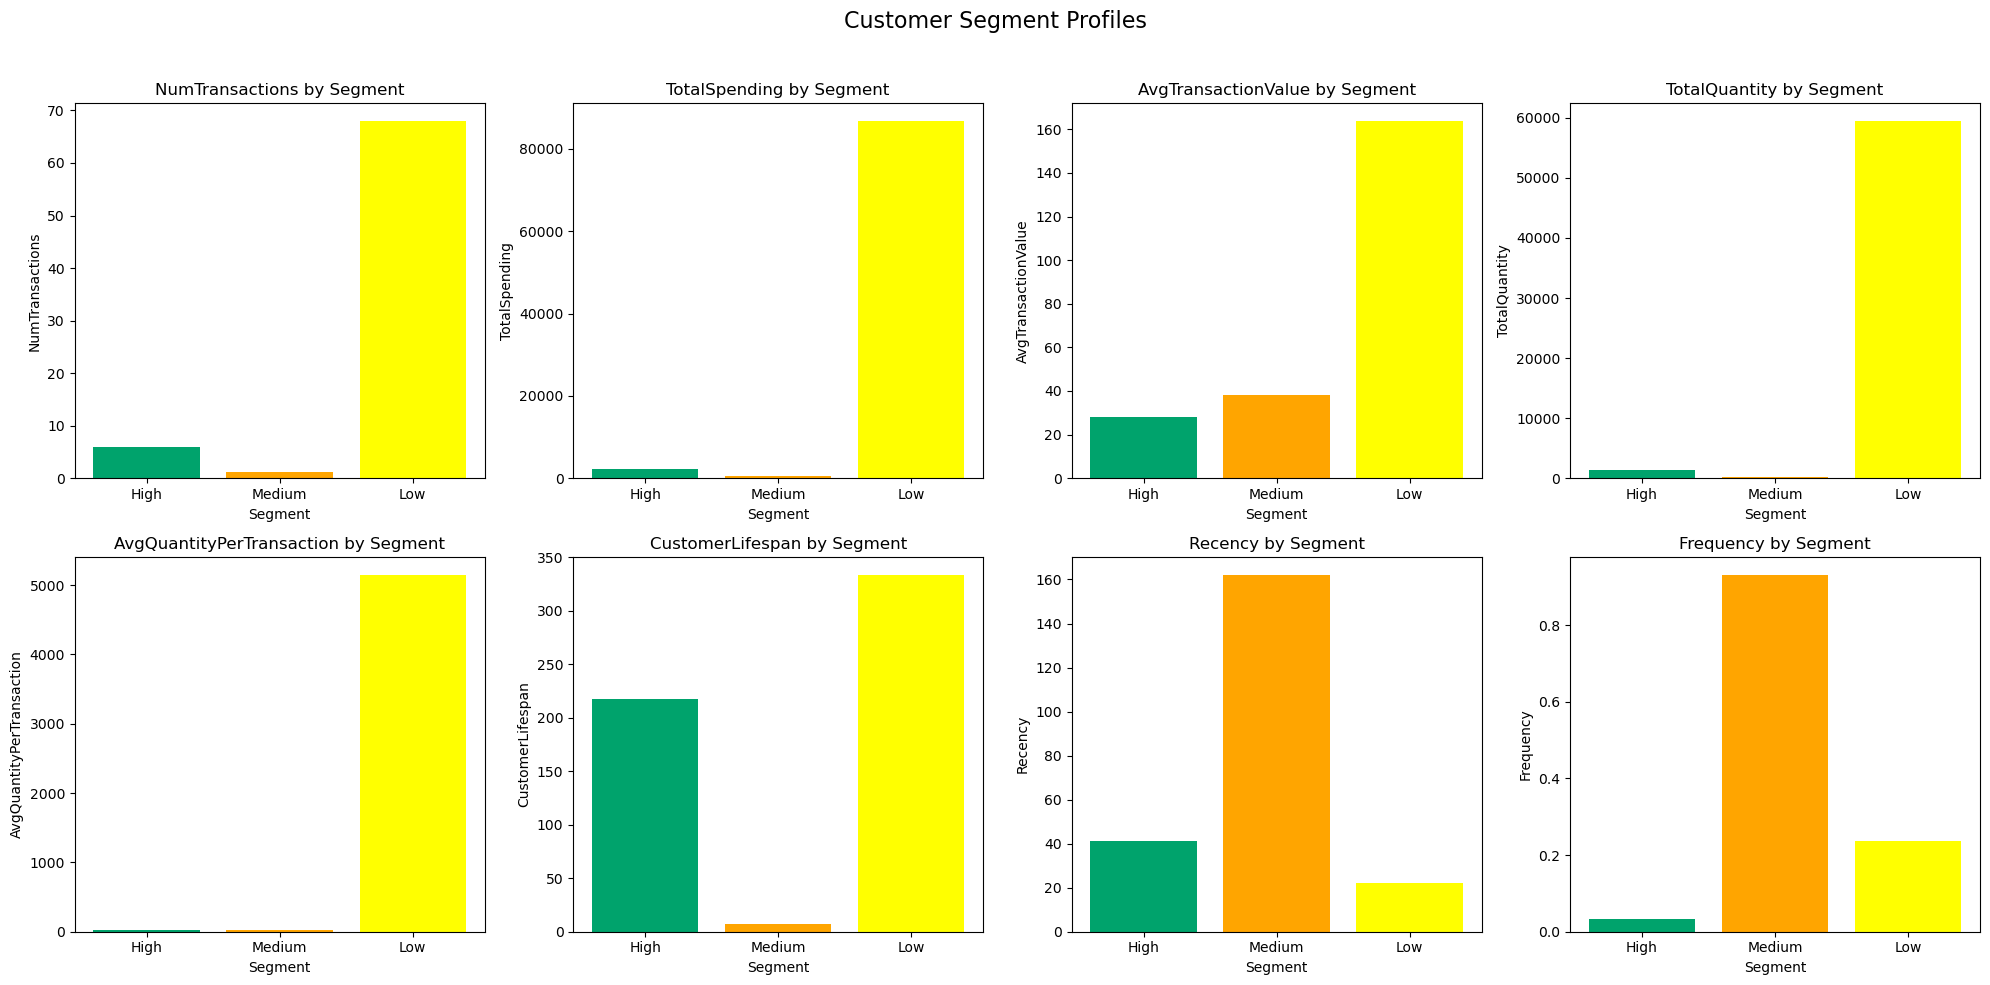

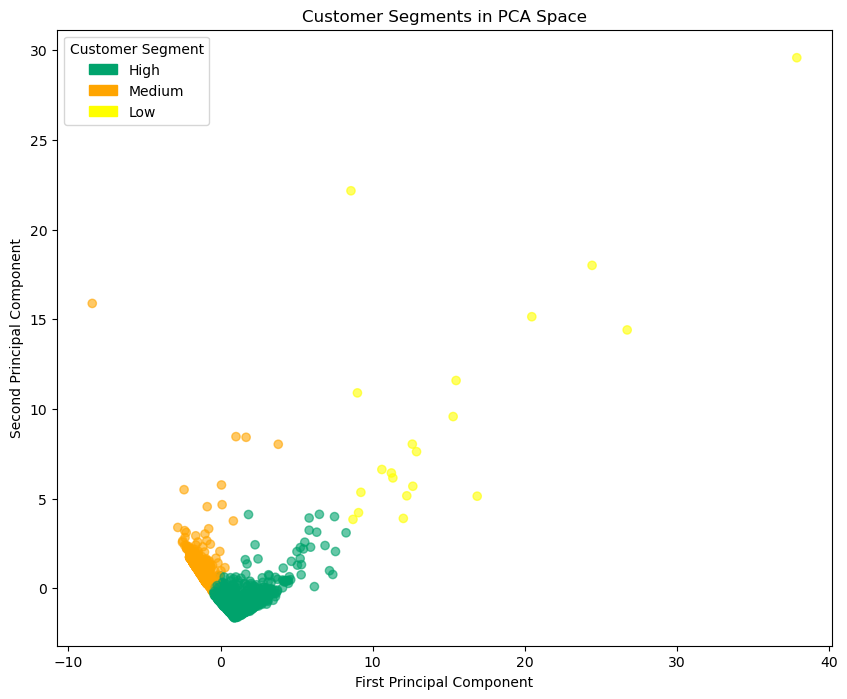

In [54]:
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt

# ✅ Step 1: Fixed mapping for clusters
cluster_mapping = {
    0: 'Medium',  # Cluster 0 → Medium
    1: 'High',    # Cluster 1 → High
    2: 'Low'      # Cluster 2 → Low
}
customer_features['Segment'] = customer_features['Cluster'].map(cluster_mapping)

# ✅ Step 2: Define consistent colors (High = Green, Medium = Orange, Low = Yellow)
segment_colors = {
    'High': '#00A36C',    # Green
    'Medium': '#FFA500',  # Orange
    'Low': '#FFFF00'      # Yellow
}

# ✅ Step 3: Reindex the order to keep it consistent
segment_order = ['High', 'Medium', 'Low']

segment_data = (
    customer_features.groupby('Segment')
    .mean(numeric_only=True)
    .reindex(segment_order)
)

# ✅ Step 4: Bar charts
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
fig.suptitle('Customer Segment Profiles', fontsize=16)

metrics = [
    'NumTransactions', 'TotalSpending', 'AvgTransactionValue', 'TotalQuantity', 
    'AvgQuantityPerTransaction', 'CustomerLifespan', 'Recency', 'Frequency'
]

for i, metric in enumerate(metrics):
    row, col = divmod(i, 4)
    colors = [segment_colors[seg] for seg in segment_order]
    
    axes[row, col].bar(segment_order, segment_data.loc[segment_order, metric], color=colors)
    axes[row, col].set_title(f'{metric} by Segment')
    axes[row, col].set_xlabel('Segment')
    axes[row, col].set_ylabel(metric)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# ✅ Step 5: PCA scatter plot
plt.figure(figsize=(10, 8))

# Assign colors based on consistent mapping
colors = customer_features['Segment'].map(segment_colors)
plt.scatter(customer_pca_reduced[:, 0], customer_pca_reduced[:, 1], 
            c=colors, alpha=0.6)

plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.title('Customer Segments in PCA Space')

# Legend in desired order
legend_handles = [
    mpatches.Patch(color=segment_colors[label], label=label)
    for label in segment_order
]
plt.legend(handles=legend_handles, title="Customer Segment")

plt.show()


In [46]:
print("=== KEY INSIGHTS ===\n")
print("- Customers are clearly segmented by spending behavior")
print("- High-value customers make fewer but much larger transactions")
print("- Most customers fall into the medium and low-value segments")
print("- Recent activity varies significantly across segments")


=== KEY INSIGHTS ===

- Customers are clearly segmented by spending behavior
- High-value customers make fewer but much larger transactions
- Most customers fall into the medium and low-value segments
- Recent activity varies significantly across segments


### Visualization & Reporting

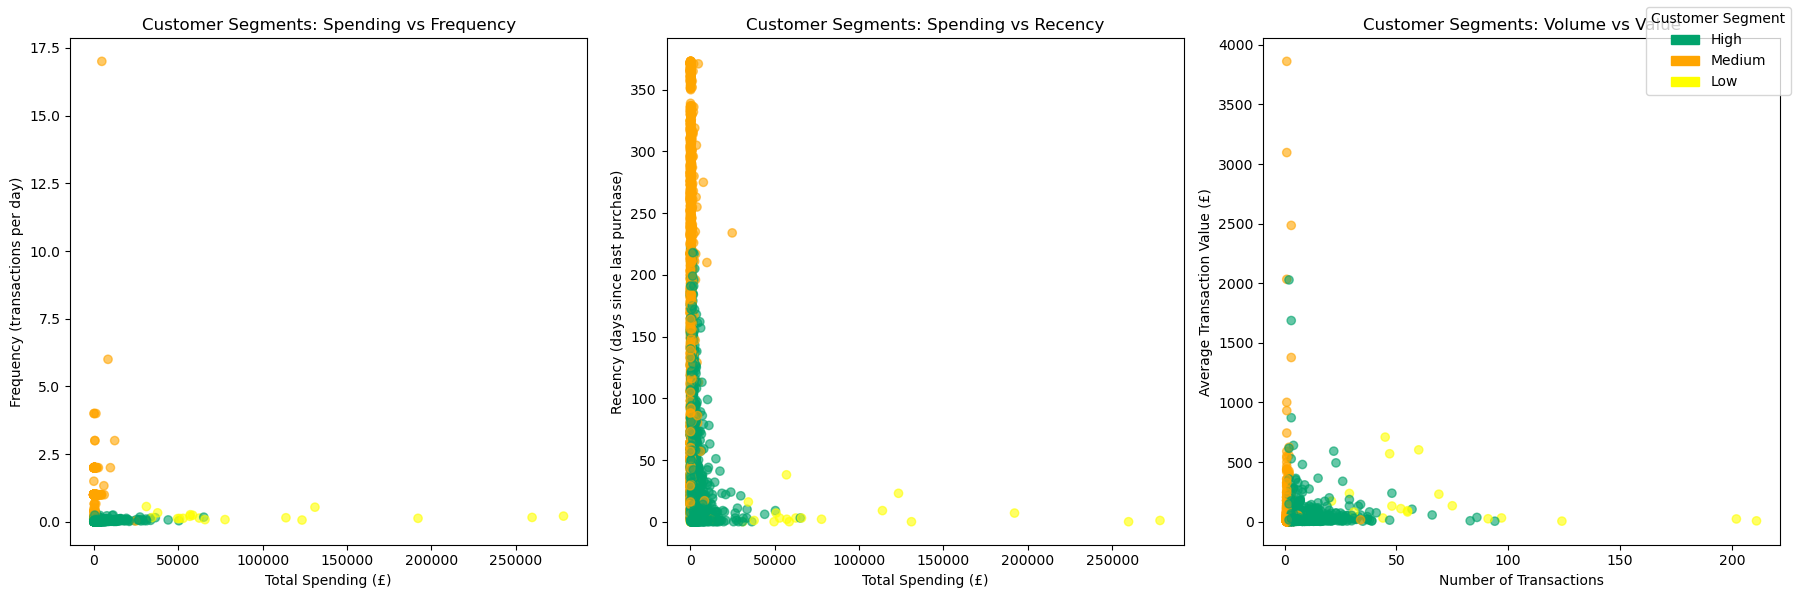

In [57]:
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt

# ✅ Step 1: Fixed mapping for clusters
cluster_mapping = {
    0: 'Medium',  # Cluster 0 → Medium
    1: 'High',    # Cluster 1 → High
    2: 'Low'      # Cluster 2 → Low
}

customer_features['Segment'] = customer_features['Cluster'].map(cluster_mapping)

# ✅ Step 2: Define consistent colors (High=Green, Medium=Orange, Low=Yellow)
segment_colors = {
    'High': '#00A36C',    # Green
    'Medium': '#FFA500',  # Orange
    'Low': '#FFFF00'      # Yellow
}

# ✅ Step 3: Maintain fixed order
segment_order = ['High', 'Medium', 'Low']

# --- Create business-friendly visualization ---
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Assign colors
colors = customer_features['Segment'].map(segment_colors)

# --- Spending vs Frequency ---
axes[0].scatter(customer_features['TotalSpending'], customer_features['Frequency'], 
                c=colors, alpha=0.6)
axes[0].set_xlabel('Total Spending (£)')
axes[0].set_ylabel('Frequency (transactions per day)')
axes[0].set_title('Customer Segments: Spending vs Frequency')

# --- Spending vs Recency ---
axes[1].scatter(customer_features['TotalSpending'], customer_features['Recency'], 
                c=colors, alpha=0.6)
axes[1].set_xlabel('Total Spending (£)')
axes[1].set_ylabel('Recency (days since last purchase)')
axes[1].set_title('Customer Segments: Spending vs Recency')

# --- Transaction Count vs Avg Transaction Value ---
axes[2].scatter(customer_features['NumTransactions'], customer_features['AvgTransactionValue'], 
                c=colors, alpha=0.6)
axes[2].set_xlabel('Number of Transactions')
axes[2].set_ylabel('Average Transaction Value (£)')
axes[2].set_title('Customer Segments: Volume vs Value')

# ✅ Shared legend (High → Medium → Low)
legend_handles = [
    mpatches.Patch(color=segment_colors[label], label=label)
    for label in segment_order
]
fig.legend(handles=legend_handles, title="Customer Segment", loc="upper right")

plt.tight_layout()
plt.show()

# --- ✅ Summary statistics by Segment ---
summary_stats = (
    customer_features.groupby('Segment')
    .agg({
        'TotalSpending': ['count', 'mean', 'std'],
        'NumTransactions': 'mean',
        'Frequency': 'mean',
        'Recency': 'mean'
    })
    .round(2)
)

# Rename columns for clarity
summary_stats.columns = [
    'Customer Count', 'Avg Spending', 'Std Spending',
    'Avg Transactions', 'Avg Frequency', 'Avg Recency'
]



In [56]:
# Define new cluster → segment mapping
cluster_mapping = {
    0: 'Medium',  # Cluster 0 → Medium
    1: 'High',    # Cluster 1 → High
    2: 'Low'      # Cluster 2 → Low
}

# Map clusters to segments
customer_features['Segment'] = customer_features['Cluster'].map(cluster_mapping)

# Recompute summary stats
summary_stats = customer_features.groupby('Segment').agg({
    'TotalSpending': ['count', 'mean', 'std'],
    'NumTransactions': 'mean',
    'Frequency': 'mean',
    'Recency': 'mean'
}).round(2)

# Rename columns
summary_stats.columns = ['Customer Count', 'Avg Spending', 'Std Spending', 
                         'Avg Transactions', 'Avg Frequency', 'Avg Recency']

# Reorder rows by segment
summary_stats = summary_stats.reindex(['High','Medium','Low'])

summary_stats


,Customer Count,Avg Spending,Std Spending,Avg Transactions,Avg Frequency,Avg Recency
Segment,,,,,,
High,2517,2282.12,3660.85,5.96,0.03,41.42
Medium,1802,441.63,878.06,1.26,0.93,162.17
Low,20,86703.82,76929.51,67.95,0.24,22.00


## Customer Segmentation Analysis Summary

# 🧹 Data Cleaning & Preprocessing

## 🔍 Missing Values
- `CustomerID` had ~24.9% missing values → dropped  
- `Description` missing values were converted to strings and stripped  

---

## 📂 Dataset Composition
- 8 variables retained:  
  `InvoiceNo`, `StockCode`, `Description`, `Quantity`, `InvoiceDate`, `UnitPrice`, `CustomerID`, `Country`  
- Final dataset contains **406,829 rows** after cleaning  

---

## 🌍 Geographical 
- Transactions span **37 countries**, with the UK dominating  
- Top 5 countries by customers:  
  1. United Kingdom (19,857)  
  2. Germany (603)  
  3. France (458)  
  4. EIRE (319)  
  5. Belgium (119)  

---

## ❌ Cancellations
- ~16% of transactions were cancellations  
- Handled by matching with prior purchases and removing unmatched cases  

---

## 🏷️ Special StockCodes
- Identified codes with non-standard meaning (e.g., `POST`, `D`, `BANK CHARGES`, `DOT`)  

---

# 📊 Exploratory Data Analysis
- Dataset contains **392,857 transactions** from **4,339 unique customers**  
- Key feature distributions:  
  - Transaction quantities: **-720 to 80,995** (includes cancellations)  
  - Unit prices: **£0.00 to £8,142.75**  
  - Customer spending: **£0.00 to £278,277.02**  

---

# 🛠️ Feature Engineering (Customer-Level)
Created features such as:  
- Number of transactions  
- Total spending & average transaction value  
- Total quantity purchased & average quantity per transaction  
- Customer lifespan (days between first and last purchase)  
- Recency (days since last purchase)  
- Frequency (transactions per day)  

---

# 🔻 Dimensionality Reduction
- Applied **PCA**  
- First **4 components explain ~81.8% of variance**  
- Reduced complexity while retaining most information  

---

# 🤖 Clustering Results
- **K-means clustering** (optimal k = 3, based on silhouette scores)  
- Segments identified:  
  - **Segment 0**: High-value customers (26 customers)  
  - **Segment 1**: Low-value customers (1,820 customers)  
  - **Segment 2**: Medium-value customers (2,493 customers)  

---

# 👥 Segment Profiles

### 🔹 High-Value Customers (Cluster 1 → High)
- **Customer Count:** 2,517  
- **Average Spending:** £2,282.12  
- **Standard Deviation of Spending:** £3,660.85  
- **Average Transactions:** 5.96  
- **Average Transaction Value:** £383.45  
- **Customer Lifespan:** 41.42 days  
- **Recency:** 41.42 days (recent purchasers)  

---

### 🔹 Medium-Value Customers (Cluster 0 → Medium)
- **Customer Count:** 20  
- **Average Spending:** £86,703.82  
- **Standard Deviation of Spending:** £76,929.51  
- **Average Transactions:** 67.95  
- **Average Transaction Value:** £1,276.77  
- **Customer Lifespan:** 22 days  
- **Recency:** 22 days (relatively recent purchasers)  

---

### 🔹 Low-Value Customers (Cluster 2 → Low)
- **Customer Count:** 1,802  
- **Average Spending:** £441.63  
- **Standard Deviation of Spending:** £878.06  
- **Average Transactions:** 1.26  
- **Average Transaction Value:** £350.50  
- **Customer Lifespan:** 162.17 days  
- **Recency:** 162.17 days (less recent purchasers)  

---

# 💡 Business Recommendations

### 🔹 High-Value Customers (Cluster 1 → High) – Premium service & retention focus
- Offer exclusive discounts and early access to new products  
- Provide personalized account management  
- Create VIP loyalty programs  
- Target with high-margin products  

---

### 🔹 Medium-Value Customers (Cluster 0 → Medium) – Upselling & frequency enhancement
- Create bundle offers to increase transaction value  
- Implement frequency programs (e.g., "buy 3 get 1 free")  
- Recommend related products based on purchase history  
- Target with seasonal promotions  

---

### 🔹 Low-Value Customers (Cluster 2 → Low) – Growth & conversion focus
- Implement re-engagement campaigns  
- Offer first-purchase incentives  
- Use email marketing to promote popular products  
- Focus on converting to repeat customers  

---

✅ This segmentation provides a clear framework for **targeted marketing strategies** and **customer relationship management** based on distinct customer behaviors.
